# Running the CUES SUMMA setup
This notebook includes background and instructions on using `pysumma` to interactively run and manipulate SUMMA simulations.
The example SUMMA setup included is for the CUES Snow Science Laboratory, a site located in the Sierra Nevada mountains.
For more information about the CUES site, [visit their website](https://snow.ucsb.edu/). 
To begin, we have to regionalize the paths in the configuration files that SUMMA will use.
This is accomplished by running a shell command. This is done by starting a line with the `!` operator.
We simply run a script to complete the installation.
Then, we can import some basic libraries along with `pysumma`.
The `%pylab inline` magic command simply imports some standard scientific packages such as `numpy` and `matplotlib`.

In [ ]:
! ./install_local_setup.sh

In [1]:
%pylab inline
import pysumma as ps
import xarray as xr

Populating the interactive namespace from numpy and matplotlib


<br>

# Interacting with SUMMA via the `Simulation` object
## Instantiating a `Simulation` object

To set up a `Simulation` object you must supply 2 pieces of information. 

First, the SUMMA executable; this could be either the compiled executable on your local machine, or a docker image. 
For this case, I'll assume that `summa.exe` is on your path. 
See the commented out `executable` for example of how you could also define the docker image. 
The string for the docker image simply came from looking at the output of the `docker images` command.

The second piece of information is the path to the file manager, which we just created through the install script.
To create the `Simulation` object you can then just pass these to the constructor as shown below.

In [4]:
executable = '/pool0/data/andrbenn/summa/bin/summa.exe'
#executable = 'docker.io/bartnijssen/summa:develop'
file_manager = './file_manager.txt'

s = ps.Simulation(executable, file_manager)

<br>

## Manipulating the configuration of the simulation object

Most of your interactions with pysumma will be facilitated through this `Simulation` object, so let's take some time to look through what is in it. 
What's contained in the `Simulation` object right after instantiation is generally just the input required for a SUMMA run.
For a more in depth discussion of what these are see the [SUMMA Input](https://summa.readthedocs.io/en/latest/input_output/SUMMA_input/) page of the documentation.
There are several attributes of interest that can be examined. 
To see each of them you can simply `print` them. 
Here's a very high level overview of what's available:

* `s.manager` - the file manager
* `s.decisions` - the decisions file
* `s.output_control` - defines what variables to write out
* `s.force_file_list` - a listing of all of the forcing files to use
* `s.local_attributes` - describes GRU/HRU attributes (lat, lon, elevation, etc)
* `s.local_param_info` - listing of spatially constant local (HRU) parameter values
* `s.basin_param_info` - listing of spatially constant basin (GRU) parameter values
* `s.parameter_trial` - spatially distributed parameter values (will overwrite `local_param_info` values, can be either HRU or GRU)

Most of these objects have a similar interface defined, with exceptions being `local_attributes` and `parameter_trial`. Those two are standard `xarray` datasets. All others follow the simple API:

```
print(x)                   # Show the data as SUMMA reads it
x.get_option(NAME)         # Get an option
x.set_option(NAME, VALUE)  # Change an option
x.remove_option(NAME)      # Remove an option
```

More intuitively, you can use `key` - `value` type indexing like dictionaries, dataframes, and datasets:

```
print(x['key'])    # Get an option
x['key'] = value   # Change an option
```

### Setting decisions

So, now that we've got a handle on what's available and what you can do with it, let's actually try some of this out. First let's just print out our decisions file so we can see what's in the defaults.


In [ ]:
print(s.decisions)

<br> 

Great, we can see what's in there. But to be able to change anything we need to know the available options for each decision. Let's look at how to do that. For arbitrary reasons we will look at the `snowIncept` option, which describes the parameterization for snow interception in the canopy. First we will get it from the `decisions` object directly, and then query what it can be changed to, then finally change the value to something else.

<br>

In [ ]:
# Get just the `snowIncept` option
print(s.decisions['snowIncept'])

# Look at what we can set it to
print(s.decisions['snowIncept'].available_options)

# Change the value 
s.decisions['snowIncept'] = 'stickySnow'
print(s.decisions['snowIncept'])

<br>

### Changing parameters

Much like the decisions we can manipulate the `local_param_info` file. First, let's look at what's contained in it

In [ ]:
print(s.local_param_info)

<br>

<br>

Yikes, that's pretty long. 
One thing that's important to know is that only the first value is used by SUMMA.
The other two columns of values are supposed to represent reasonable ranges for auto-calibration, but this feature is not yet implemented.
For now we can ignore the right two columns.
Like the decisions we can change things. See:

In [ ]:
# Print it
print(s.local_param_info['albedoMax'])

# Change the value
s.local_param_info['albedoMax'] = 0.7
print(s.local_param_info['albedoMax'])

<br>

### Modifying output
And one more, we can also modify what get's written to output. 
The output control file represents the options available through columns of numeric values.
These numbers represent how to write the output. 
From the SUMMA documentation they are arranged as:

```
! varName          | outFreq | inst | sum | mean | var | min | max | mode
```

As before, let's look at what's in the `output_control` by simply printing it out.

<br>

In [ ]:
print(s.output_control)

<br>

Then, we can modify values in a couple of ways.

<br>

In [ ]:
# Just change the frequency to daily output
print(s.output_control['scalarNetRadiation'])

# Change the output statistic from hourly instantaneous to daily total
s.output_control['scalarNetRadiation'] = [24, 1, 0, 0, 0, 0, 0, 0]
print(s.output_control['scalarNetRadiation'])

# Change it back
s.output_control['scalarNetRadiation'] = [1, 0, 1, 0, 0, 0, 0, 0]
print(s.output_control['scalarNetRadiation'])

<br>

## Running pysumma and manipulating output

Now that you've had an overview of how you can interact with SUMMA configurations through pysumma let's run a simulation. 
Before doing so we will reset our `Simulation` object, which will discard all of the changes we've made and load in a clean setup. 
Alternatively you could simply instantiate a new `Simulation` object.
After running the simulation, we will make sure that it completed successfully by checking the status.


In [ ]:
s.reset()
# Or you could just create a new simulation object like before:
#s = ps.Simulation(executable, file_manager)

s.run('local', run_suffix='_default')
assert s.status == 'Success'

<br>

You can view the standard output and error of the simulation with the `s.stdout` and `s.stderr` if you ever encounter any issues. They should be `print`'ed to render the newlines correctly. I only print out the last portion here for simplicity. You should see `FORTRAN STOP: finished simulation successfully.` if all is good.

In [ ]:
print(s.stdout[-780:])

<br>
With a complete run, we can look at the output simply by using the simulation's `output` attribute.
It is simply an xarray dataset, which can be manipulated in all of the usual ways.

In [ ]:
obs = xr.open_dataset('./validation/cues_2011-2019.nc')

In [ ]:
s.output['scalarSWE'].plot(label='SUMMA')
obs['swe'].plot(label='Observation')
plt.legend()

In [ ]:
(100 * s.output['scalarSnowDepth']).plot(label='SUMMA') # Convert to cm
obs['snow_depth'].plot(label='Observation')
plt.ylabel('Snow depth [cm]')
plt.legend()

## Changing the snow layering

In this example we will change the snow layering scheme so that only a maximum of 2 layers will ever exist. We do this by making it so that the amount of snow needed to split layers is very large. We will also make sure we are using the `CLM_2010` snow layering scheme.

<div class="alert alert-block alert-warning" style="background: lemonchiffon; padding: 8px">
<b>Note:</b> 
    Once you have started the run with `s_2layer.run(...)` the settings chosen will be written to disk. You can restore the default settings by checking out the original setup in git with `git reset --hard`. Alternatively, you may just want to back things up locally.
</div>


In [ ]:
s_2layer = ps.Simulation(executable, file_manager)
s_2layer.decisions['snowLayers']  = 'CLM_2010'

In [ ]:
# No 3rd, 4th, and 5th layers until > 100 meters of snow (AKA never)
s_2layer.local_param_info['zminLayer3'] = 100.
s_2layer.local_param_info['zminLayer4'] = 100.
s_2layer.local_param_info['zminLayer5'] = 100.
s_2layer.local_param_info['zmaxLayer2_lower'] = 9000.
s_2layer.local_param_info['zmaxLayer3_lower'] = 9000.
s_2layer.local_param_info['zmaxLayer4_lower'] = 9000.
s_2layer.local_param_info['zmaxLayer2_upper'] = 9000.
s_2layer.local_param_info['zmaxLayer3_upper'] = 9000.
s_2layer.local_param_info['zmaxLayer4_upper'] = 9000.

# Set the top layer to grow to a maximum of 25 cm before the second layer is created
s_2layer.local_param_info['zminLayer1'] = 0.0075
s_2layer.local_param_info['zmaxLayer1_lower'] = 0.250
s_2layer.local_param_info['zmaxLayer1_upper'] = 0.250

# If there's no error, the layer parameters are good to go
s_2layer.validate_layer_params(s.local_param_info)

In [ ]:
s_2layer.run('local', run_suffix='_2layer')
assert s_2layer.status == 'Success'

In [ ]:
s_2layer.output['scalarSWE'].plot(label='SUMMA 2 Layer')
s.output['scalarSWE'].plot(label='SUMMA default')
obs['swe'].plot(label='Observation')
plt.legend()

## Some fancy plotting capabilities

Now, we see that the above gives different results but we can't quite see that the 2 layer model has only 2 layers.
To verify this we can plot the layer temperature through time.
We can also do this for the original 5 layer model.
To simplify the plots we will select out only a single year.

In [2]:
plot_dates = slice('10-01-2016', '07-30-2017')
temp_2l = s_2layer.output['mLayerTemp'].sel(time=plot_dates, hru=1)
depth_2l = s_2layer.output['iLayerHeight'].sel(time=plot_dates, hru=1)

temp_5l = s.output['mLayerTemp'].sel(time=plot_dates, hru=1)
depth_5l = s.output['iLayerHeight'].sel(time=plot_dates, hru=1)

NameError: name 's_2layer' is not defined

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

axes[0].set_ylabel('Snow depth (m)')
axes[0].set_title('2 Layer model')
axes[1].set_ylabel('Snow depth (m)')
axes[1].set_title('5 Layer model')
ps.plotting.layers(temp_2l, depth_2l, ax=axes[0], variable_range=[260, 273])
ps.plotting.layers(temp_5l, depth_5l, ax=axes[1], variable_range=[260, 273])
plt.tight_layout()

# Running ensembles of different decisions and/or parameters
It would be cumbersome and time-consuming to create many different simulation objects and run them all separately.
To facilitate faster exploration pysumma implements an `Ensemble` class which will manage simulations for you.
Before running the ensemble though, let's just reset the status of the repo so that we are back at a 5 layer model.
We can do this by re-writing the original simulation's configuration.
Alternatively, if you get to a point where things are very messed up, just run `git reset --hard`.
Future versions of pysumma will alleviate the need to keep track of this by writing out new configurations for each simulation.

In [ ]:
s._write_configuration()

Now that we've got that out of the way let's create an ensemble of simulations that try out different values of the albedo decay rate.
We will try out 4 values and run each of them in parallel.

In [11]:
decay_rates = {'albedoDecayRate': np.array([1.0e+5, 5.0e+5, 1.0e+6, 5.0e+6])}
config = ps.ensemble.parameter_product(decay_rates)
param_ens = ps.Ensemble(executable, config, file_manager, num_workers=4)

Running this ensemble is similar to running a simulation.
Following execution we will loop through each of the underlying simulations to make sure nothing went wrong.
A note on the names: the ensemble uses `++` as a delimiter to create unique identifiers for each simulation.

In [6]:
param_ens.run('local')

In [7]:
for name, sim in param_ens.simulations.items():
    print(name, sim.status)

++albedoDecayRate=100000.0++ Success
++albedoDecayRate=500000.0++ Success
++albedoDecayRate=1000000.0++ Success
++albedoDecayRate=5000000.0++ Success


If all went well, we will want to collect all of the output files into one nice dataset.
Because each of the simulations was written to a separate output file we have to do this via the ensemble object.
As you can see, in the merged output there is a new dimension labeled `albedoDecayRate`, which allows us to easily select out and analyze the data.
For now, let's just plot the SWE for an arbitrary year for each of the runs to see what happened.

In [8]:
param_ds = param_ens.merge_output()
param_ds

/pool0/data/andrbenn/workspace/pysumma/pysumma/ensemble.py:108: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  full = xr.open_mfdataset(out_file_paths, concat_dim='run_number')
/pool0/data/andrbenn/.conda/all/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied do not have global dimension coordinates. In
future, to continue concatenating without supplying dimension
coordinates, please use the new `combine_nested` function (or the
`combine='nested'` option to open_mfdataset.
  from_openmfds=True,


<xarray.Dataset>
Dimensions:                    (albedoDecayRate: 4, gru: 1, hru: 1, ifcToto: 15, midToto: 14, time: 74472)
Coordinates:
  * time                       (time) datetime64[ns] 2010-10-01 ... 2019-03-30T23:00:00.000013312
  * hru                        (hru) int32 1
  * albedoDecayRate            (albedoDecayRate) float64 1e+05 5e+05 1e+06 5e+06
Dimensions without coordinates: gru, ifcToto, midToto
Data variables:
    pptrate                    (time, hru, albedoDecayRate) float64 dask.array<chunksize=(74472, 1, 1), meta=np.ndarray>
    airtemp                    (time, hru, albedoDecayRate) float64 dask.array<chunksize=(74472, 1, 1), meta=np.ndarray>
    SWRadAtm                   (time, hru, albedoDecayRate) float64 dask.array<chunksize=(74472, 1, 1), meta=np.ndarray>
    LWRadAtm                   (time, hru, albedoDecayRate) float64 dask.array<chunksize=(74472, 1, 1), meta=np.ndarray>
    hruId                      (hru, albedoDecayRate) int64 dask.array<chunksize=(1, 

/pool0/data/andrbenn/.conda/all/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


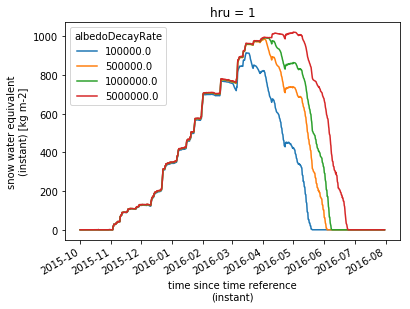

In [9]:
plot_dates = slice('10-01-2015', '07-30-2016')
param_ds.sel(time=plot_dates, hru=1, drop=True)['scalarSWE'].plot.line(x='time')

Similarly, we may want to try out different decisions.
The ensemble class can do this as well.
Let's create an ensemble of both these 4 albedo decay rate options as well as two options for how the decay curve is computed.
SUMMA has a decision called `alb_method` that has 2 options: `conDecay` for constant decay and `varDecay` for variable decay.
The difference between these methods can be found in the SUMMA papers and technical note.
For now, we will do similarly as with the parameter ensemble, but now we will have 8 runs instead of 4.
That is, there are 2 albedo decay methods times 4 albedo decay rates.

In [22]:
del param_ens

NameError: name 'param_ens' is not defined

In [19]:
decay_methods = {'alb_method': ['conDecay', 'varDecay']}
config = ps.ensemble.total_product(dec_conf=decay_methods, param_conf=decay_rates)

In [24]:
albedo_ens = ps.Ensemble(executable, config, file_manager, num_workers=4)

In [25]:
albedo_ens.simulations

{'++albedoDecayRate=100000.0++': Executable path: /pool0/data/andrbenn/summa/bin/summa.exe
 Simulation status: Uninitialized
 File manager configuration:
 None,
 '++albedoDecayRate=500000.0++': Executable path: /pool0/data/andrbenn/summa/bin/summa.exe
 Simulation status: Uninitialized
 File manager configuration:
 None,
 '++albedoDecayRate=1000000.0++': Executable path: /pool0/data/andrbenn/summa/bin/summa.exe
 Simulation status: Uninitialized
 File manager configuration:
 None,
 '++albedoDecayRate=5000000.0++': Executable path: /pool0/data/andrbenn/summa/bin/summa.exe
 Simulation status: Uninitialized
 File manager configuration:
 None,
 '++conDecay++albedoDecayRate=100000.0++': Executable path: /pool0/data/andrbenn/summa/bin/summa.exe
 Simulation status: Uninitialized
 File manager configuration:
 None,
 '++conDecay++albedoDecayRate=500000.0++': Executable path: /pool0/data/andrbenn/summa/bin/summa.exe
 Simulation status: Uninitialized
 File manager configuration:
 None,
 '++conDecay